In [403]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as pl
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima_model import ARIMA

In [463]:
df = pd.read_csv('../data/avocado_modeling_file.csv')

In [468]:
df = df.dropna()

### Linear Regression for a baseline

In [469]:


df_lr = df.drop('Date', axis = 1).select_dtypes('number')
target = 'AveragePrice'
X = df_lr.drop(target, inplace = False, axis = 1)
y = df_lr[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 12)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
preds = regressor.predict(X_train)
resid = (preds-y_train).values

In [470]:
y = np.zeros(len(x))

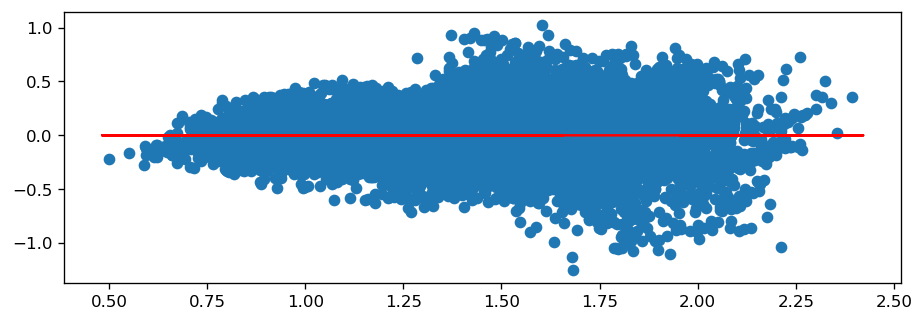

In [471]:
plt.scatter(preds, resid)
plt.plot(x, y, color = 'red')

In [472]:
r2_score(y_train, preds)

0.6420201358760596

In [473]:
mean_squared_error(y_train, preds)

0.058069778156947256

### ARIMA forecast for Total Volume

In [474]:

df['Date'] = pd.to_datetime(df['Date'])
df_arima = df.set_index('Date')
pd.DatetimeIndex(df_arima.index).to_period('W')
df_arima = df_arima.select_dtypes(['number', 'datetime'])

<ipython-input-474-507626069a54>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


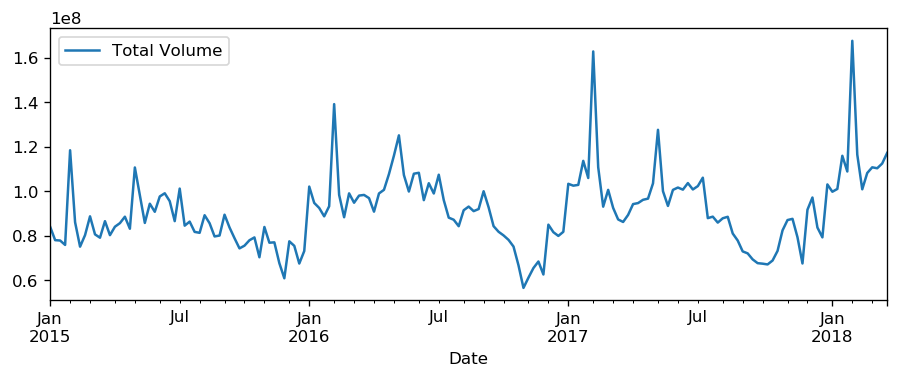

In [475]:
#Volume seems seasonal -- can we use an ARIMA model for this or should we go SARIMA?

test_gb = df.groupby('Date', as_index = False).agg({'Total Volume':'sum'})
test_gb.plot('Date', 'Total Volume')

In [476]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(test_gb['Total Volume'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.946055
p-value: 0.040249


In [477]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

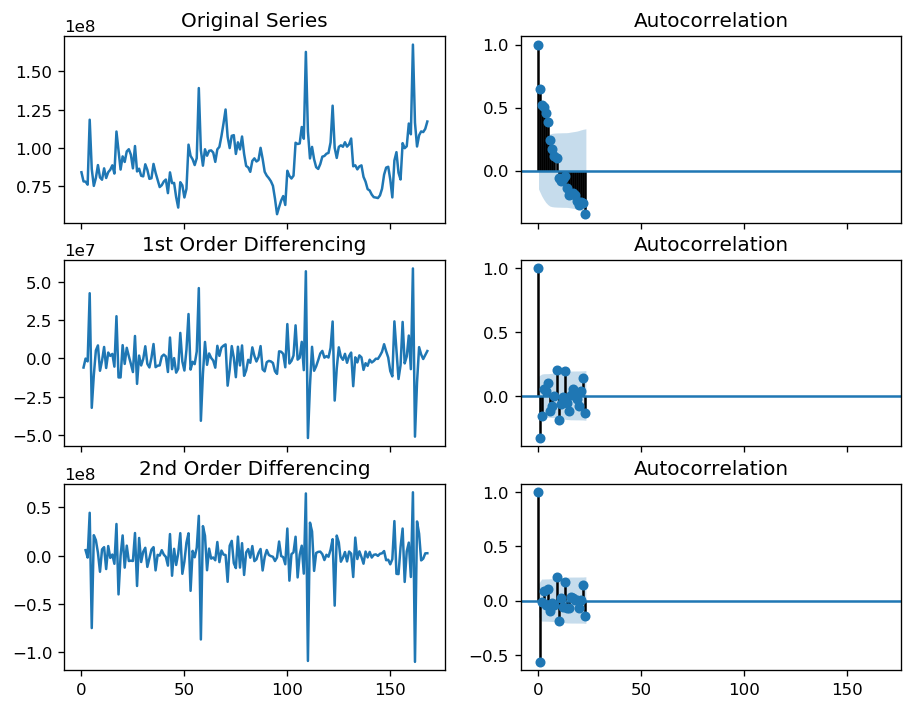

In [478]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(test_gb['Total Volume']); axes[0, 0].set_title('Original Series')
plot_acf(test_gb['Total Volume'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(test_gb['Total Volume'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(test_gb['Total Volume'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(test_gb['Total Volume'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(test_gb['Total Volume'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [479]:
from pmdarima.arima.utils import ndiffs

print('adf test: ' + str(ndiffs(test_gb['Total Volume'], test='adf')))
print('kpss test: ' + str(ndiffs(test_gb['Total Volume'], test='kpss')))
print('pp test: ' + str(ndiffs(test_gb['Total Volume'], test='pp')))

adf test: 1
kpss test: 0
pp test: 0


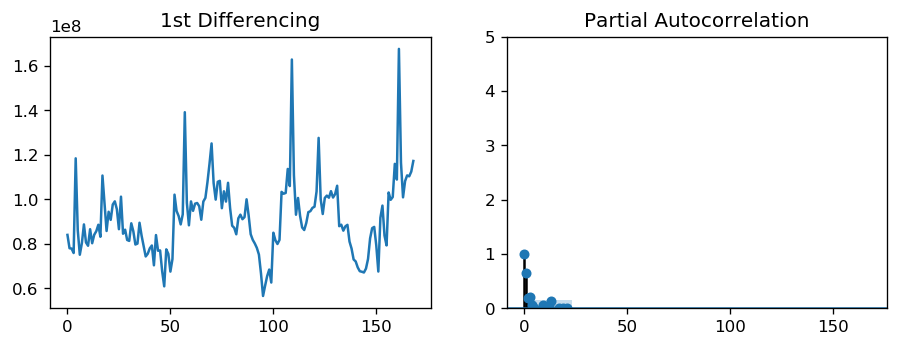

In [480]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(test_gb['Total Volume']); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(test_gb['Total Volume'], ax=axes[1])

plt.show()

In [481]:
model_df = test_gb.set_index('Date')
model = ARIMA(model_df['Total Volume'], order=(1,1,1), freq = 'W')
model_fit = model.fit(disp=0)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Total Volume   No. Observations:                  168
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2980.040
Method:                       css-mle   S.D. of innovations       12218726.220
Date:                Tue, 07 Apr 2020   AIC                           5968.081
Time:                        17:36:48   BIC                           5980.577
Sample:                    01-11-2015   HQIC                          5973.152
                         - 03-25-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.976e+05   4.32e+05      0.457      0.648    -6.5e+05    1.05e+06
ar.L1.D.Total Volume     0.1293      0.144      0.900      0.368      -0.152       0.411
ma.L1.D.Total Volume    -0.6040      0.114     -5.280      0.000      -0.828      -0.380
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            7.7329           +0.0000j            7.7329            0.0000
MA.1            1.6557           +0.0000j            1.6557            0.0000
-----------------------------------------------------------------------------
"""

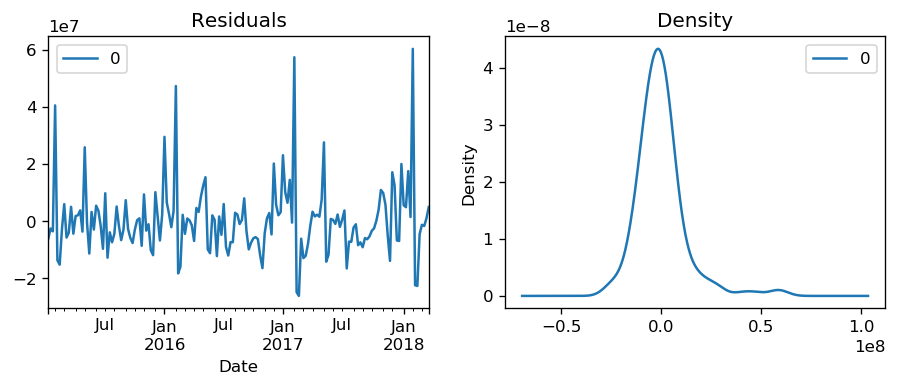

In [482]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

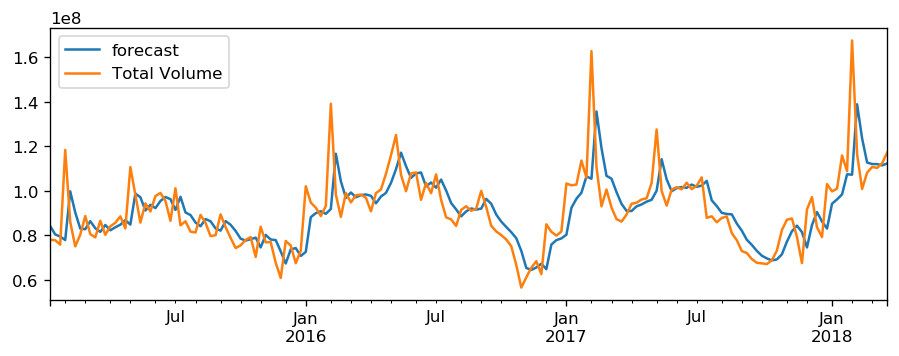

In [483]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [484]:
train = model_df.sort_index()[:150]
test = model_df.sort_index()[150:]

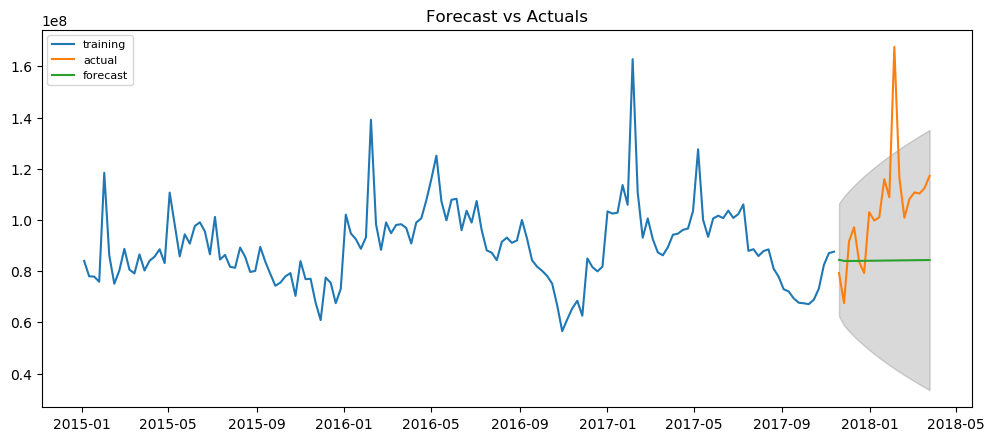

In [485]:
model = ARIMA(train, order=(1, 1, 1), freq = 'W')  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(19, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [486]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

In [487]:
forecast_accuracy(fc, test.values.flatten())

{'mape': 0.19823490262814392,
 'me': -19572452.118554734,
 'mae': 22377510.964168835,
 'mpe': -0.15908856128020712,
 'rmse': 28236235.004195534,
 'corr': 0.32573710170880354,
 'minmax': 0.19533679611213228}

In [488]:
import pmdarima as pm

model = pm.auto_arima(model_df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=5625.801, BIC=5641.083, Time=0.184 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=5771.890, BIC=5778.003, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 12) (constant=True); AIC=5657.577, BIC=5669.802, Time=0.106 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=5705.882, BIC=5718.107, Time=0.148 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=False); AIC=5771.871, BIC=5774.927, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 1, 0, 12) (constant=True); AIC=5681.617, BIC=5693.842, Time=0.065 seconds
Fit ARIMA: (1, 0, 1)x(1, 1, 1, 12) (constant=True); AIC=5627.793, BIC=5646.130, Time=0.196 seconds
Fit ARIMA: (1, 0, 1)x(0, 1, 2, 12) (constant=True); AIC=5627.732, BIC=5646.069, Time=0.413 seconds
Fit ARIMA: (1, 0, 1)x(1, 1, 0, 12) (constant=True); AIC=5650.984, BIC=5666.265, Time=0.155 seconds
Fit ARIMA: (1, 0, 1)x(1, 1, 2, 12) (constant=True); AIC=5629.377,

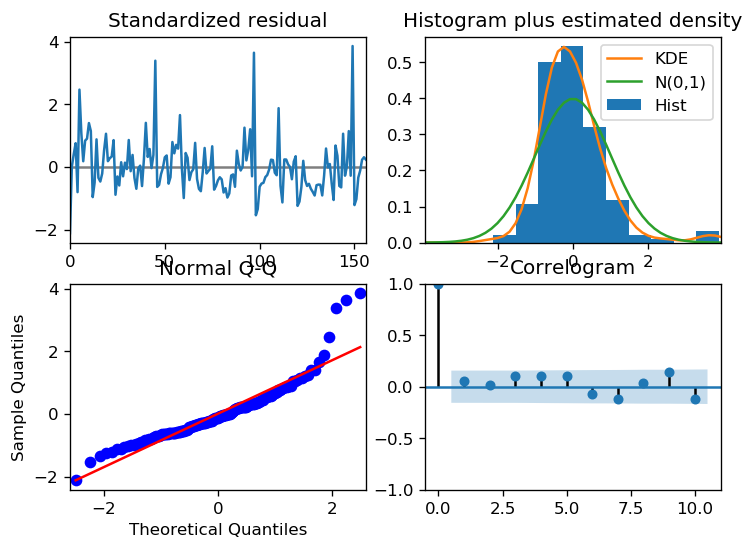

In [489]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

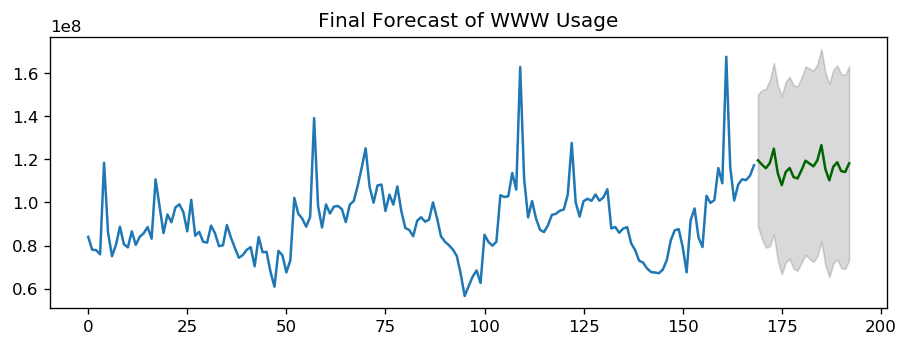

In [490]:
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(test_gb), len(test_gb)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(test_gb['Total Volume'])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

### Meh, I'm not impressed by either the ARIMA or SARIMAX models

In [504]:
X_tv = df.select_dtypes('number')

In [505]:
X_tv = X_tv.drop(['4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags'], 
          axis = 1)

In [506]:
y_tv = df['Total Volume']

In [507]:
test_index = df[pd.to_datetime(df['Date']) < pd.to_datetime(df['Date']).max()
                - pd.to_timedelta(26, unit='w')].index

In [510]:
test_index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            17591, 17592, 17593, 17594, 17595, 17596, 17597, 17598, 17599,
            17600],
           dtype='int64', length=14197)

In [513]:
X_tv_train = X_tv.loc[test_index, : ]

In [514]:
y_tv_train = y_tv[test_index]

In [515]:
X_tv_test = X_tv.drop(X_tv_train.index)

In [516]:
y_tv_test = y_tv.drop(y_tv_train.index)

In [518]:
X_tv_train

,AveragePrice,Total Volume,year,Month,Week,lat,long,type_organic,region_Atlanta,region_BaltimoreWashington,...,Week_49,Week_5,Week_50,Week_51,Week_52,Week_53,Week_6,Week_7,Week_8,Week_9
0,1.33,64236.62,2015,12,52,42.651167,-73.754968,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1.35,54876.98,2015,12,51,42.651167,-73.754968,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0.93,118220.22,2015,12,50,42.651167,-73.754968,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1.08,78992.15,2015,12,49,42.651167,-73.754968,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1.28,51039.60,2015,11,48,42.651167,-73.754968,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17596,1.30,17839.37,2017,1,4,26.271197,-98.326610,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17597,1.21,16430.64,2017,1,3,26.271197,-98.326610,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17598,1.19,17014.23,2017,1,2,26.271197,-98.326610,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17599,1.18,14375.39,2017,1,1,26.271197,-98.326610,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [583]:
rf_tv_model = RandomForestRegressor(random_state=4, n_estimators = 1)

In [584]:
rf_tv_model.fit(X_tv_train, y_tv_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1, n_jobs=None, oob_score=False,
                      random_state=4, verbose=0, warm_start=False)

In [585]:
preds = rf_tv_model.predict(X_tv_test)

In [586]:
test = df.loc[df.index.isin(test_index),:].merge(pd.DataFrame(preds, columns = ['preds']),
                left_index = True, right_index = True)

In [587]:
test = test.groupby('Date', as_index = False).agg({'Total Volume' : 'sum', 'preds' : 'sum'})

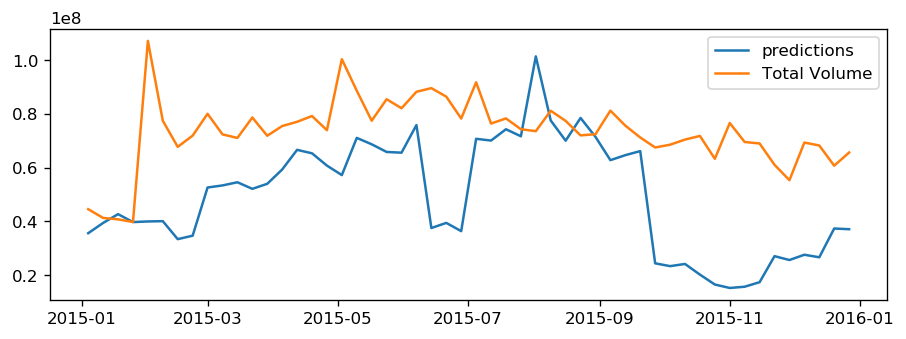

In [588]:
# Rolled up analysis
plt.plot(test['Date'], test["preds"], label = 'predictions')
plt.plot(test['Date'], test['Total Volume'], label = 'Total Volume')
plt.legend()

In [589]:
r2_score(preds, y_tv_test)

0.9997817198210701

In [590]:
resid_tv = (preds - y_tv_test).values

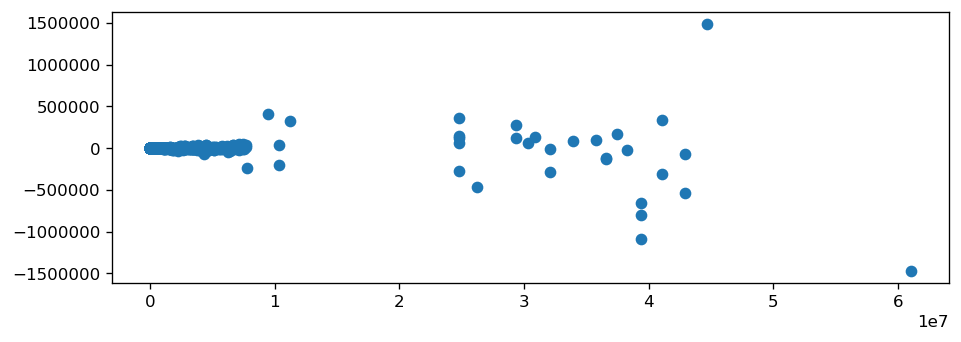

In [591]:
plt.scatter(preds, resid_tv)
#plt.plot(x, y, color = 'red')